In [8]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../')

In [9]:
import os
import math

import numpy
import pandas
import librosa
import soundfile

from matplotlib import pyplot as plt
import librosa.display
import seaborn

from brewaed import utils, labels, beerbubble
from brewaed.plotting import plot_events
import brewaed



In [10]:

samplerate=8000
window_length=0.064
feature_hop = int(window_length*samplerate)


In [11]:
def load_dataset(path):
    df = pandas.read_csv(path)
    df = df.set_index('id')
    
    return df

data_dir = '../data'
files_path = os.path.join(data_dir, 'files.csv')

files = load_dataset(files_path)
files['path'] = os.path.join(data_dir, 'audio') + os.path.sep + files.filename 
files

,youtube_url,filename,brews,path
id,,,,
MN0Mg1uyznU,https://www.youtube.com/watch?v=MN0Mg1uyznU,ASMR _ Homebrewing Airlock Symphony 🍺🎼 Soothin...,3,../data/audio/ASMR _ Homebrewing Airlock Symph...
by0e-EkAsOE,https://www.youtube.com/watch?v=by0e-EkAsOE,One hour of apple wine airlock bubbling-by0e-E...,1,../data/audio/One hour of apple wine airlock b...
q2srYoC3FOo,https://www.youtube.com/watch?v=q2srYoC3FOo,Bubbling airlock on pear cider-q2srYoC3FOo.m4a,1,../data/audio/Bubbling airlock on pear cider-q...
p0jtxp5nWms,https://www.youtube.com/watch?v=p0jtxp5nWms,Watch an Airlock Bubbling During Mead Fermenta...,1,../data/audio/Watch an Airlock Bubbling During...
f3bLQLT48Yc,https://www.youtube.com/watch?v=f3bLQLT48Yc,Ginger beer brewing day nine-f3bLQLT48Yc.m4a,1,../data/audio/Ginger beer brewing day nine-f3b...
WHlSNkq29k4,https://www.youtube.com/watch?v=WHlSNkq29k4,Airlock during fermentation.-WHlSNkq29k4.m4a,1,../data/audio/Airlock during fermentation.-WHl...
51ytpDZj8v4,https://www.youtube.com/watch?v=51ytpDZj8v4,Elderflower Airlock-51ytpDZj8v4.m4a,1,../data/audio/Elderflower Airlock-51ytpDZj8v4.m4a
gQFo3Lg2MAc,https://www.youtube.com/watch?v=gQFo3Lg2MAc,Airlock bubbler_Home brewing-gQFo3Lg2MAc.m4a,1,../data/audio/Airlock bubbler_Home brewing-gQF...
po2u_qI7-us,https://www.youtube.com/watch?v=po2u_qI7-us,S-Style Beer_Wine Air Lock Bubbling-po2u_qI7-u...,1,../data/audio/S-Style Beer_Wine Air Lock Bubbl...


In [12]:
def get_id_from_labelpath(p):
    f = os.path.basename(p)
    prefix, id = f.split('.')
    assert prefix == 'labels', prefix
    return id

def load_labels(label_dir):

    paths = [ os.path.join(label_dir, f) for f in os.listdir(label_dir) ]

    ids = list(map(get_id_from_labelpath, paths))
    
    files = pandas.DataFrame({
        'path': paths,
        'id': ids,
    }).set_index('id')
    
    labels = files.groupby(by='id').apply(lambda r: brewaed.labels.read(r.path.iloc[0]))
    
    return labels

label_dir = os.path.join(data_dir, 'labels')
labels = load_labels(label_dir)
labels['duration'] = labels['end'] - labels['start']
labels['color'] = labels['annotation'].replace(dict(p='green', n='red'))
print(labels.color.value_counts(dropna=False))
labels
#brewaed.labels.read(ll.path.iloc[0])




color
green    737
red      130
Name: count, dtype: int64


start     end annotation  duration  color
id                                                        
51ytpDZj8v4 0    0.640   1.024          p     0.384  green
            1    2.048   2.432          p     0.384  green
            2    3.328   3.712          p     0.384  green
            3    4.736   5.120          p     0.384  green
            4    6.144   6.400          p     0.256  green
...                ...     ...        ...       ...    ...
q2srYoC3FOo 9   37.376  37.760          p     0.384  green
            10  44.416  44.672          p     0.256  green
            11  51.072  51.328          p     0.256  green
            12  56.832  56.960          n     0.128    red
            13  57.600  57.984          p     0.384  green

[867 rows x 5 columns]

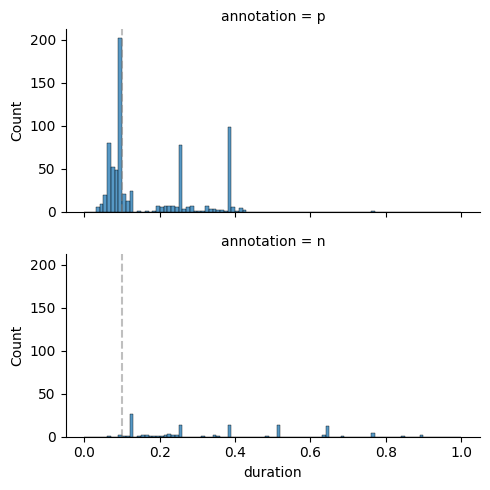

In [13]:
g = seaborn.displot(data=labels, kind='hist',
                x='duration',
                row='annotation',
                binwidth=0.010,
                binrange=(0, 1.0),
                height=2.5,
                aspect=2,
               )
g.refline(x=0.100, alpha=0.5) 


In [14]:
feature_hop/8000

0.064

In [15]:
import soundfile

In [16]:
def load_spectrogram(path, hop_length=1024, sr=16000, start=0.0, end=1*60.0):
    feature_fft = utils.next_power_of_2(feature_hop*2)
    
    audio, sr = librosa.load(path, sr=sr, offset=start, duration=end-start)
    ff = librosa.stft(y=audio, hop_length=feature_hop, n_fft=feature_fft)
    S = librosa.amplitude_to_db(numpy.abs(ff))
    
    return S

labeled_files = files.loc[labels.reset_index().id.unique()]
specs = labeled_files.path.apply(load_spectrogram, hop_length=feature_hop, sr=samplerate)
specs


/tmp/ipykernel_141534/4016642028.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(path, sr=sr, offset=start, duration=end-start)
/home/jon/projects/emlearn/venv/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_141534/4016642028.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(path, sr=sr, offset=start, duration=end-start)
/home/jon/projects/emlearn/venv/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_141534/4016642028.py:4: UserWarning: PySoundFile failed. Tryi

id
51ytpDZj8v4    [[-50.309193, -50.309193, -50.309193, -50.3091...
MN0Mg1uyznU    [[-65.726715, -65.726715, -65.726715, -65.7267...
WHlSNkq29k4    [[-61.8123, -35.561188, -22.221039, -22.461838...
ZPmEByu-4xQ    [[-90.00714, -76.68826, -42.063145, -48.357243...
by0e-EkAsOE    [[-48.786407, -28.179152, -46.46374, -32.64861...
f3bLQLT48Yc    [[-65.35197, -34.616318, -56.223164, -44.22980...
gQFo3Lg2MAc    [[-68.90515, -60.671066, -32.501106, -33.76901...
p0jtxp5nWms    [[-28.570269, 0.1869942, -8.809397, -7.6133065...
po2u_qI7-us    [[-74.34378, -74.34378, -74.34378, -74.34378, ...
q2srYoC3FOo    [[-54.274715, -54.274715, -30.663488, -36.2253...
Name: path, dtype: object

In [17]:
# Goal: Get BPM estimation of plops working on DollarML, at PoC level
# Thesis: using STFT with mean summarization, log scaled, combined with RandomForest, is sufficient to detect plops
# either using single frame, or 2 frames / frame+diff, or 3 frames
# 
# spectral subtraction might give a good boost in performance. Rolling over say last 10 seconds
#
# Thesis: Doing event thresholding, and median difference, 
# 60 seconds at 100 ms resolution is 600 bytes of uint8. Can look at last N=60 events. Compute median time difference from that?


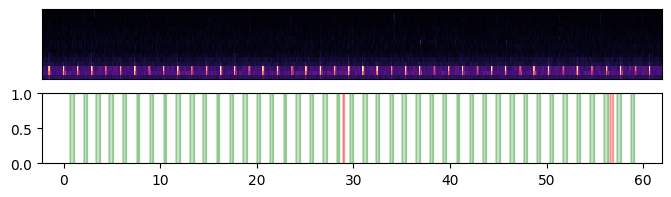

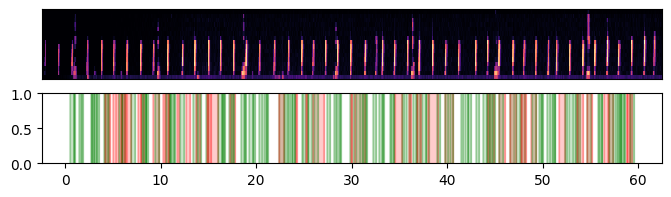

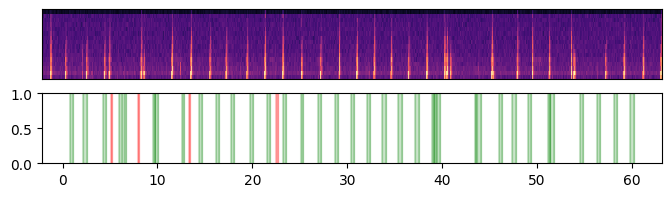

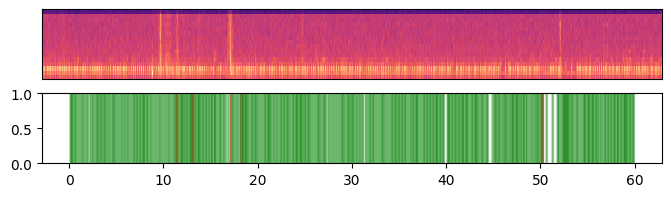

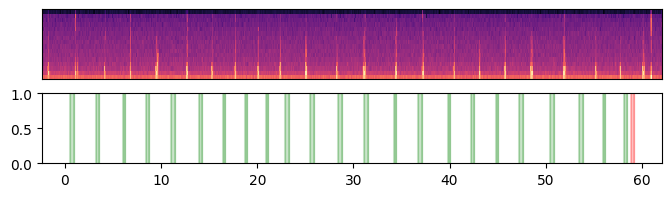

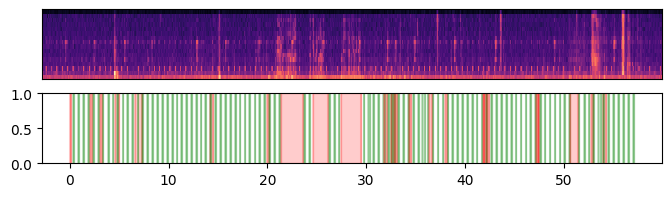

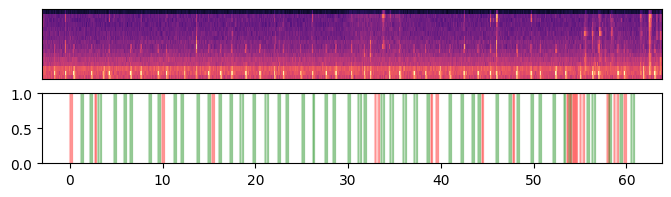

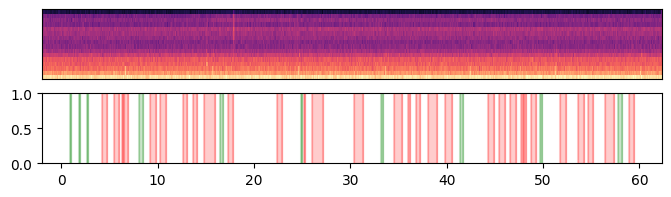

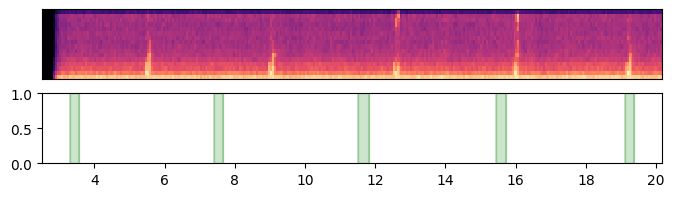

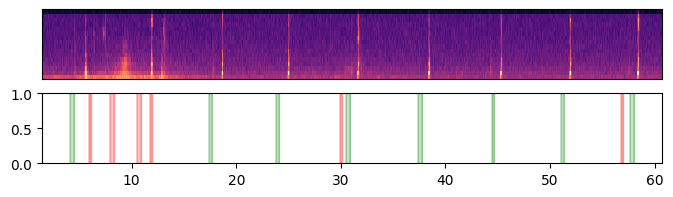

In [18]:

def spectrum_mean(S, bins=32):
    fft_bins, length = S.shape
    out = numpy.zeros(shape=(bins, length))
    binwidth = fft_bins // bins
    
    for i in range(bins):
        s = i*binwidth
        e = (i+1)*binwidth
        out[i, :] = numpy.mean(S[s:e, :], axis=0)

    return out

def preprocess_spectrogram(spec,
                           bins=16,
                           spectral_subtraction=False):
    m = spectrum_mean(spec, bins=bins)  
    if spectral_subtraction:
        avg = numpy.mean(m, axis=1, keepdims=True)
        m = m - avg # spectral subtraction
    return m

def plot_spectrogram(ax, spec, labels=None, title=None):
    librosa.display.specshow(spec, ax=ax)

for clip in labels.reset_index()['id'].unique():
    l = labels.loc[clip]
    s = specs.loc[clip]
    #print(l.annotation.value_counts(), s.shape)

    # s
    s = preprocess_spectrogram(s)
    fig, (ax, ax2) = plt.subplots(2, figsize=(8.0, 2.0), sharex=False)
    plot_spectrogram(ax=ax, spec=s, labels=l, title=clip)
    plot_events(ax=ax2, df=l, color='color', label='annotation')



In [19]:

audio_features = specs.apply(preprocess_spectrogram, spectral_subtraction=True)

audio_features.iloc[0].shape


(16, 938)

In [20]:

from brewaed.sed_utils import events_from_predictions, \
    merge_overlapped_predictions, \
    weighted_binary_crossentropy, \
    build_sednet, \
    compute_pr_curve, \
    compute_windows, \
    make_continious_labels





In [21]:

def make_label_tracks(spectrograms, labels, time_resolution):

    def make_one(row):
        spec = row.path
        idx = row.name
        lab = labels.loc[idx]
        length = spec.shape[1]
        #print(length)
        l = make_continious_labels(lab[lab.annotation == 'p'], length, time_resolution)
        return l
    
    return spectrograms.to_frame().apply(make_one, axis=1)

time_resolution = 0.064
label_tracks = make_label_tracks(audio_features, labels, time_resolution)

label_tracks.iloc[0]
None

In [22]:
def make_windows(spectrograms, labels, window_length, window_hop=None):
    if window_hop is None:
        window_length = window_hop
    
    def make_one(row):
        spec = row.path
        label = labels.loc[row.name].values.T
        windows = pandas.DataFrame({
            'spectrogram': compute_windows(spec, frames=window_length, step=window_hop),
            'labels': compute_windows(label, frames=window_length, step=window_hop),
        })
        windows['event'] = windows.labels.apply(lambda labels: numpy.any(labels, axis=-1)).astype(int)
        return windows

    out = spectrograms.to_frame().apply(make_one, axis=1)
    return out

windows = make_windows(audio_features, label_tracks, window_length=16, window_hop=4)
windows.iloc[0].shape


(235, 3)

In [23]:
from brewaed.sed_utils import flatten_dataframes
ww = flatten_dataframes(windows)
ww

spectrogram  \
id          start_index                                                      
51ytpDZj8v4 0            [[-10.324745857385174, -10.324745857385174, -1...   
            4            [[-1.7650801774535338, 0.1799500349488099, 1.1...   
            8            [[-0.0007521745238463495, -0.31271811690665885...   
            12           [[0.8766930464234193, 0.11332253250740365, -1....   
            16           [[-0.023071968225018225, -1.0932166215453307, ...   
...                                                                    ...   
q2srYoC3FOo 920          [[-5.0680370620573, -2.537378340133472, -3.002...   
            924          [[-1.645389585861011, -2.523870497115894, -4.8...   
            928          [[-2.3276157668912845, -2.9941826156461673, -3...   
            932          [[-2.1810207656705813, -3.68870356596355, -2.5...   
            936          [[-3.9147243789518313, -3.4129734329069095, 0....   

                                                                    labels  \
id          start_index                                                      
51ytpDZj8v4 0            [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
            4            [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0,...   
            8            [[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
            12           [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
            16           [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                                    ...   
q2srYoC3FOo 920          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
            924          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
            928          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
            932          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
            936          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                         event  
id          start_index         
51ytpDZj8v4 0                1  
            4                1  
            8                1  
            12               0  
            16               0  
...                        ...  
q2srYoC3FOo 920              0  
            924              0  
            928              0  
            932              0  
            936              0  

[2184 rows x 3 columns]

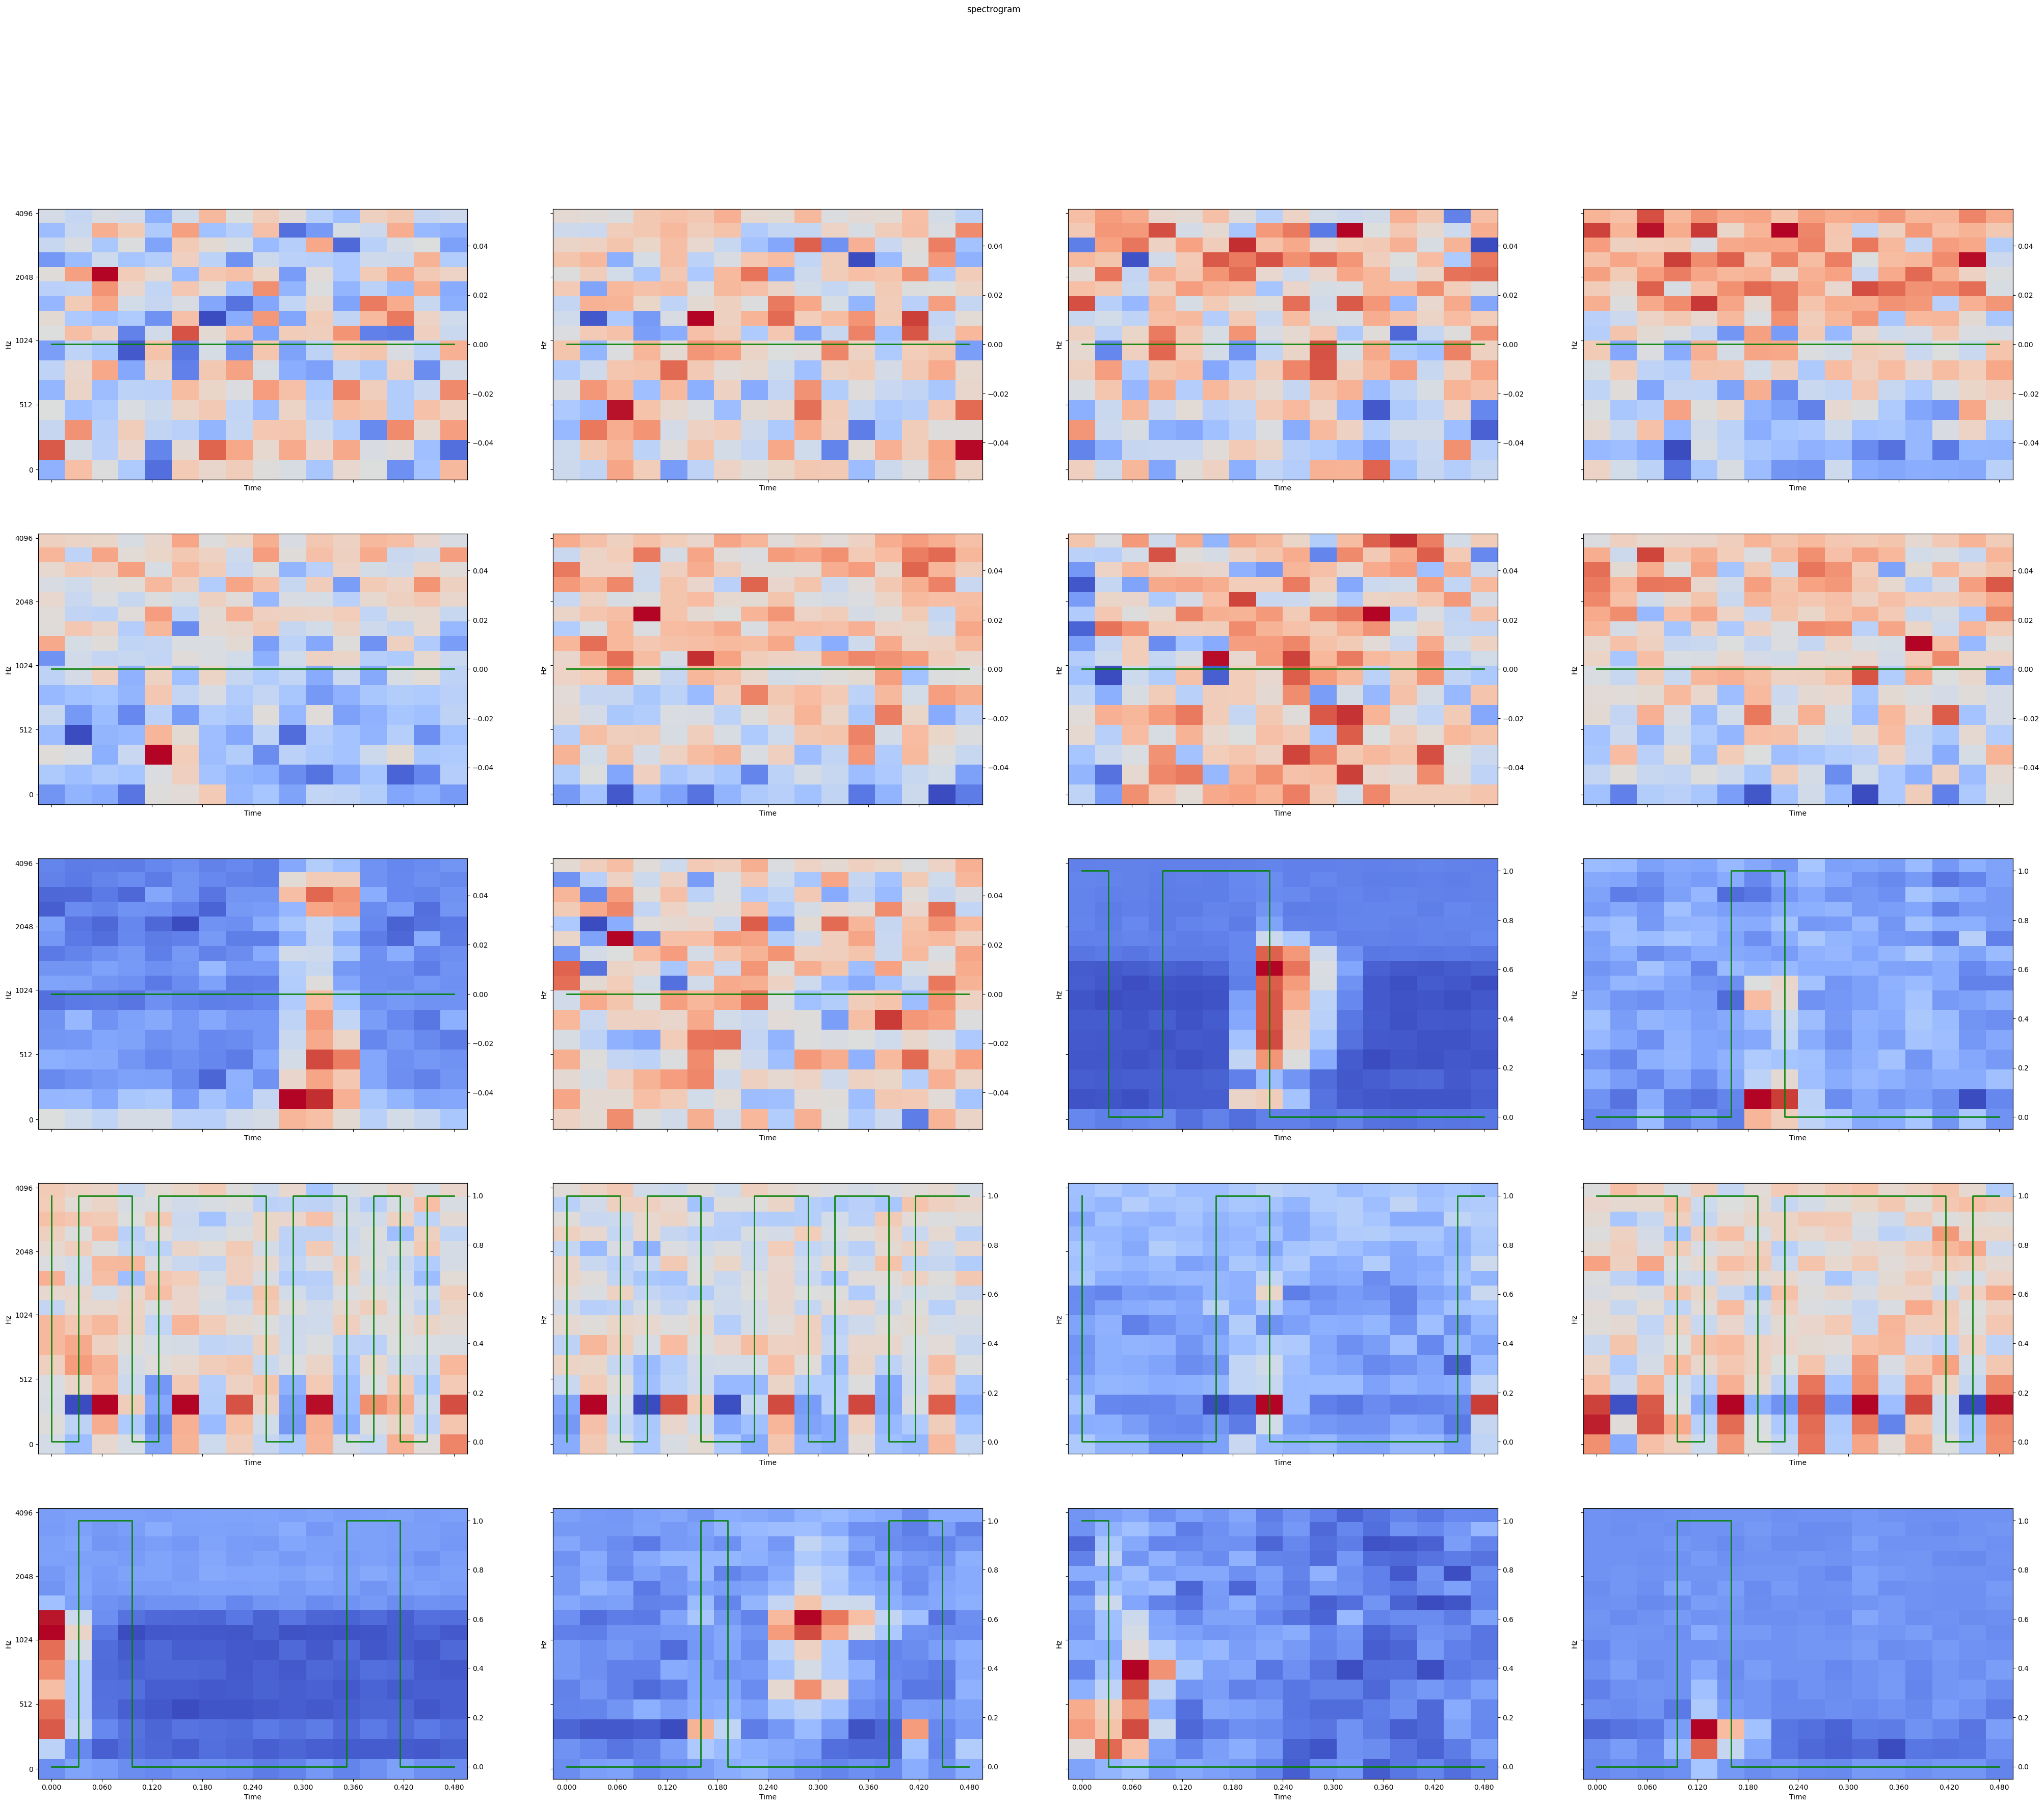

In [26]:

from brewaed.plotting import plot_windows

plot_windows(ww.groupby('event', as_index=False).sample(n=10), hop_length=256, samplerate=8000, height=10, col_wrap=5)



In [28]:


import tensorflow.keras
from brewaed import sed_utils

def build_model(input_shape, dropout=0.5, lr=0.01, class_weights=None, name='sedgru'):

    from brewaed.sed_utils import build_sedgru, build_sednet
    
    # Model
    if name == 'sednet':
        model = build_sednet(input_shape, n_classes=1,                         filters=10,
                         cnn_pooling=[2, 2, 2],
                         rnn_units=[5, 5],
                         dense_units=[16],
                         dropout=dropout,
                        )
    elif name == 'sedgru':
        model = build_sedgru(input_shape, n_classes=1,
                             reduction_units=(8,),
                             rnn_units=[5, 5],
                             dense_units=[16],
                             dropout=dropout)
    else:
        raise ValueError('')
        
    # Metrics
    pr_auc = tensorflow.keras.metrics.AUC(num_thresholds=200, curve="PR", name='pr_auc')
    precision = tensorflow.keras.metrics.Precision(name='precision')
    recall = tensorflow.keras.metrics.Recall(name='recall')
    
    # Loss
    if class_weights is None:
        loss = tensorflow.keras.losses.BinaryCrossentropy()
    else:
        loss = weighted_binary_crossentropy(*class_weights)
       
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=lr),
                  loss=loss,
                  metrics=[pr_auc, precision, recall],
    )
    return model

model = build_model(input_shape=(16, 16))
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16)]          0         
                                                                 
 time_distributed (TimeDist  (None, 16, 8)             136       
 ributed)                                                        
                                                                 
 bidirectional (Bidirection  (None, 16, 5)             450       
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 16, 5)             360       
 onal)                                                           
                                                                 
 time_distributed_1 (TimeDi  (None, 16, 16)            96        
 stributed)                                                  

In [ ]:

epochs = 400
batch_size = 8*64

from tqdm.keras import TqdmCallback

def get_XY(split=None):
    # convenience to convert
    #d = dataset[dataset.split == split]
    d = ww
    
    X = numpy.expand_dims(numpy.stack([s.T for s in d.spectrogram]), -1)
    Y = numpy.stack([ l.T for l in d.labels], axis=0)    
    return X, Y

train = get_XY(split='train')
val = get_XY(split='val')

#from sed_utils import compute_class_weights

#class_weights = compute_class_weights(train[1])
#class_weights = None # disable class weights
#print('Class weights', class_weights)

# make sure to stop when model does not improve anymore / starts overfitting
early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
progress_bar = TqdmCallback()

model = build_model(input_shape=(16, 16), dropout=0.33, lr=2*0.001)
hist = model.fit(x=train[0], y=train[1],
        validation_data=val,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[
            progress_bar,
            #early_stop,
        ],
        verbose=False, # using progress bar callback instead
)


0epoch [00:00, ?epoch/s]
  0%|                                                                                                                                            | 0/400 [00:00<?, ?epoch/s]
  0%|                                                                                                                                        | 0.00/5.00 [00:00<?, ?batch/s]
 20%|██████████████▍                                                         | 1.00/5.00 [00:15<01:02, 15.5s/batch, loss=0.695, pr_auc=0.176, precision=0.168, recall=0.555]
  0%| | 1/400 [00:17<1:57:02, 17.60s/epoch, loss=0.688, pr_auc=0.158, precision=0.163, recall=0.275, val_loss=0.674, val_pr_auc=0.17, val_precision=0.335, val_recall=0.0251
  0%|                                                                               | 0.00/5.00 [00:00<?, ?batch/s, loss=0.688, pr_auc=0.158, precision=0.163, recall=0.275]
  0%| | 2/400 [00:17<49:31,  7.47s/epoch, loss=0.667, pr_auc=0.17, precision=0.213, recall=0.0473, val_loss=0.

In [ ]:
import sklearn.model_selection
splitter = sklearn.model_selection.GroupKFold(n_splits=4)
folds = list(splitter.split(windows, groups=windows.reset_index().file))
for fold_no, (train_idx, test_idx) in enumerate(folds):
    print(fold_no, len(train_idx), len(test_idx))

train, test = windows.iloc[folds[0][0]], windows.iloc[folds[0][1]]
#train = windows.iloc[train]
#test = windows.iloc[test]



In [ ]:

def build_model():
    
    import sklearn.pipeline
    import sklearn.preprocessing
    import sklearn.linear_model
    import sklearn.svm
    import sklearn.neighbors
    from sklearn.compose import make_column_transformer
    from sklearn.compose import make_column_selector

    model = sklearn.pipeline.Pipeline([
        ('scale', sklearn.preprocessing.StandardScaler()),
        ('classifier', sklearn.linear_model.LogisticRegression()),
    ])

    return model

def get_features(df):
    return numpy.array([f for f in df.feature])

m = build_model()
m.fit(get_features(train), train.label == 'p')

In [ ]:
def predict(model, windows):
    
    X = get_features(windows)
    Y = m.predict_proba(X)[:,1]
    
    pred = pandas.DataFrame({
      'probability': Y,
    }, index=windows.index)

    pred = pred.merge(windows, left_index=True, right_index=True)
    
    return pred

predict(m, train)
    

In [ ]:
import sklearn.metrics
#Y_pred = m.predict(get_features(train))
#sklearn.metrics.f1_score(Y_pred, train.label == 'p')

sklearn.metrics.f1_score(predict(m, test).probability > 0.1, test.label == 'p')

In [ ]:
# TODO: plot PR / ROC curves

pred = predict(m, train)
pred

In [ ]:
def get_events(pred):
    pred = pred.copy()
    sparse, dense = utils.mark_onoff(pred.set_index('time').probability, on_threshold=0.6, off_threshold=0.4)
    out = sparse
    
    return out

all_preds = predict(m, windows)
events = all_preds.reset_index().groupby('file').apply(get_events)
events

In [ ]:
def n_events(df):
    return numpy.count_nonzero(df)
events.groupby('file').apply(n_events)

In [ ]:
labels[labels.annotation == 'p'].reset_index().groupby('id').count()

In [ ]:
def ggg(df):
    df = df[df == 1].reset_index()    
    t = df['level_1']
    
    return t.diff().dropna().rename('diff')
    
p = events.groupby('file').apply(ggg).rename("diff")

In [ ]:
def gg(df):
    return df['start'].diff().dropna().rename('diff')

h = labels[labels.annotation == 'p'].reset_index().groupby('id').apply(gg)
import seaborn


In [ ]:
# TODO: make plots use one ax per file, overlay predictions with labels
fig, axs = plt.subplots(2, sharex=True)
seaborn.kdeplot(ax=axs[0], data=h.reset_index(), x='diff', hue='id')
seaborn.kdeplot(ax=axs[1], data=p.reset_index(), x='diff', hue='file')

In [ ]:
# TODO: compute metrics on BPM 

def get_bpm(diffs):
    return 60.0 / diffs.median()
    
bpm h.groupby('id').apply(get_bpm)

In [ ]:
p.groupby('file').apply(get_bpm)